# Import Libraries and Data

In [1]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

fatal: destination path 'Financial_Sentiment_LLM' already exists and is not an empty directory.


In [3]:
# Load prepped data
gemini_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/04_Stock_Modeling/Flat_Stock_Data/Gemini_Prompt2/02_Prompt2_Gemini_Prepped_Stock_Data.csv')
print(gemini_sentiment.shape)
display(gemini_sentiment.head())
print(gemini_sentiment.isna().sum())

(9474, 12)


,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
0,ProQuest,PQ-2463687415,BP,2019-01-09,https://www.proquest.com/newspapers/markets-co...,Positive,Neutral,Positive,Neutral,Neutral,Neutral,0.008244
1,ProQuest,PQ-2311280728,BP,2019-02-11,https://www.proquest.com/newspapers/arabia-sau...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.006589
2,Investment Research,IR-4891,BP,2019-02-20,NaN,Positive,Positive,Neutral,Neutral,Neutral,Positive,0.002360
3,ProQuest,PQ-2300507429,BP,2019-03-10,https://www.proquest.com/newspapers/bp-ceo-ste...,Positive,Neutral,Neutral,Negative,Neutral,Neutral,0.001894
4,ProQuest,PQ-2311444292,BP,2019-03-11,https://www.proquest.com/newspapers/aramco-arr...,Positive,Neutral,Neutral,Neutral,Negative,Neutral,0.001894


Source             0
Unique_ID          0
Ticker             0
Date               0
URL             4887
Finance            0
Production         0
Reserves/M&A       0
Regulatory         0
Green Energy       0
OG Price           0
Returns            0
dtype: int64


In [4]:
# Filter to SEC Filings
gemini_sentiment = gemini_sentiment[gemini_sentiment['Source'].str.contains('SEC Filings')]
print(gemini_sentiment.shape)
display(gemini_sentiment.head())

(1019, 12)


,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
20,SEC Filings,SEC-114036119010687,BP,2019-07-06,https://www.sec.gov/Archives/edgar/data/000031...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.001219
163,SEC Filings,SEC-31380720000008,BP,2020-06-23,https://www.sec.gov/Archives/edgar/data/000031...,Neutral,Neutral,Neutral,Negative,Neutral,Negative,0.012568
383,SEC Filings,SEC-31380721000009,BP,2021-11-06,https://www.sec.gov/Archives/edgar/data/000031...,Neutral,Neutral,Neutral,Neutral,Neutral,Negative,-0.001095
536,SEC Filings,SEC-31380722000025,BP,2022-10-06,https://www.sec.gov/Archives/edgar/data/000031...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.007648
648,SEC Filings,SEC-31380723000020,BP,2023-06-13,https://www.sec.gov/Archives/edgar/data/000031...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.008916


In [5]:
# Drop extra columns
gemini_sentiment = gemini_sentiment.drop(['Unique_ID','URL'], axis=1)

# Convert the 'Date' column to datetime
gemini_sentiment['Date'] = pd.to_datetime(gemini_sentiment['Date'])

# Sort by date for Grid Search using Time Split later
gemini_sentiment = gemini_sentiment.sort_values(by='Date')
gemini_sentiment = gemini_sentiment.reset_index(drop=True)
display(gemini_sentiment.head())
display(gemini_sentiment.tail())

,Source,Ticker,Date,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
0,SEC Filings,XOM,2019-01-02,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.005200
1,SEC Filings,CVX,2019-01-02,Positive,Neutral,Neutral,Neutral,Neutral,Neutral,-0.004365
2,SEC Filings,MPC,2019-01-04,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.049005
3,SEC Filings,DVN,2019-01-05,Neutral,Neutral,Negative,Neutral,Neutral,Neutral,0.002662
4,SEC Filings,VLO,2019-01-05,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.054515


,Source,Ticker,Date,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
1014,SEC Filings,VLO,2024-05-20,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.013730
1015,SEC Filings,HES,2024-05-21,Negative,Neutral,Negative,Neutral,Neutral,Neutral,-0.007829
1016,SEC Filings,MRO,2024-05-23,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.004250
1017,SEC Filings,EOG,2024-05-24,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.006128
1018,SEC Filings,OXY,2024-06-05,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.000835


# One Hot Encode and Split Data

In [6]:
# One hot encode categorical variables
gemini_sentiment_encoded = pd.get_dummies(gemini_sentiment, columns=['Ticker',
                                                                     'Source',
                                                                     'Finance',
                                                                     'Production',
                                                                     'Reserves/M&A',
                                                                     'Regulatory',
                                                                     'Green Energy',
                                                                     'OG Price'], drop_first=True)
display(gemini_sentiment_encoded.head())

,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
0,2019-01-02,0.005200,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
1,2019-01-02,-0.004365,False,True,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
2,2019-01-04,0.049005,False,False,False,False,False,True,False,False,...,True,False,True,False,True,False,True,False,True,False
3,2019-01-05,0.002662,False,False,True,False,False,False,False,False,...,True,False,False,False,True,False,True,False,True,False
4,2019-01-05,0.054515,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False


In [7]:
# Split into test and train
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = gemini_sentiment_encoded[(gemini_sentiment_encoded['Date'] < split_date)]
test_df = gemini_sentiment_encoded[gemini_sentiment_encoded['Date'] >= split_date]

display(train_df.tail())
display(test_df.head())

,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
943,2023-12-06,-0.012106,False,False,True,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
944,2023-12-12,-0.026463,False,False,False,False,False,False,False,True,...,True,False,False,True,True,False,True,False,True,False
945,2023-12-13,0.006884,False,False,False,True,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
946,2023-12-21,-0.006314,False,False,False,False,False,True,False,False,...,True,False,True,False,True,False,True,False,True,False
947,2023-12-28,-0.017530,False,False,False,False,False,False,False,True,...,True,False,False,True,True,False,True,False,True,False


,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
948,2024-01-03,0.020885,False,False,False,False,False,False,True,False,...,True,False,True,False,True,False,True,False,True,False
949,2024-01-05,0.008685,False,False,False,False,False,False,True,False,...,True,False,True,False,True,False,True,False,True,False
950,2024-01-05,-0.010053,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
951,2024-01-05,0.006794,False,False,True,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
952,2024-01-22,0.005672,False,False,False,False,False,False,False,True,...,True,False,False,True,True,False,True,False,True,False


In [8]:
# Define X and y
X_train = train_df.drop(columns=['Date','Returns'])
X_test = test_df.drop(columns=['Date','Returns'])

y_train = train_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)
y_test = test_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)

print(len(X_train), len(y_train), len(X_test), len(y_test))
display(X_train.head())
display(y_train.head())

948 948 71 71


,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,Ticker_PSX,Ticker_VLO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
0,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
2,False,False,False,False,False,True,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
3,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,True,False,True,False,True,False
4,False,False,False,False,False,False,False,False,False,True,...,True,False,True,False,True,False,True,False,True,False


0    1
1    0
2    1
3    1
4    1
Name: Returns, dtype: int64

# Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        34
           1       0.55      0.49      0.51        37

    accuracy                           0.52        71
   macro avg       0.52      0.52      0.52        71
weighted avg       0.52      0.52      0.52        71



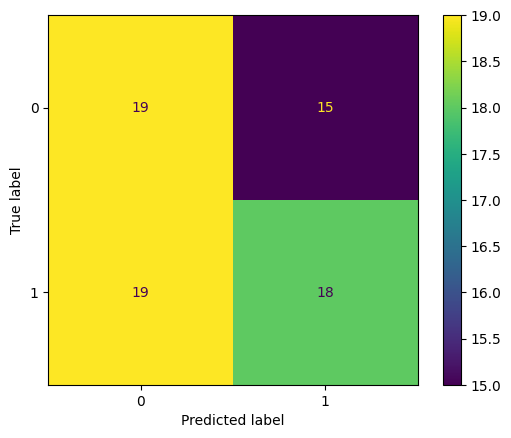

In [9]:
# Baseline Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 10, 'max_features': None, 'n_estimators': 500}
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.54        34
           1       0.56      0.51      0.54        37

    accuracy                           0.54        71
   macro avg       0.54      0.54      0.54        71
weighted avg       0.54      0.54      0.54        71



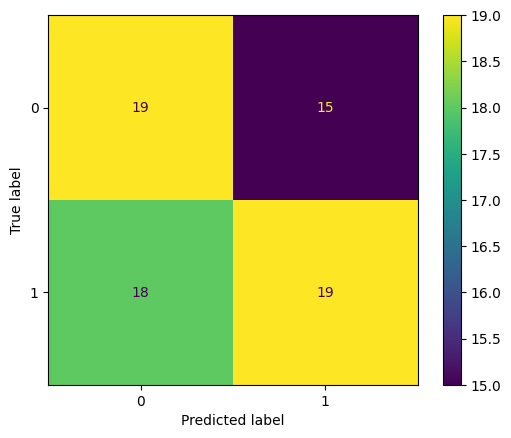

In [10]:
# Random Forest Tuned with GridSearchCV

# Define the parameter grid
param_grid = {
   'n_estimators': [500],
   'max_depth': [None, 10, 20, 30],
   'max_features': [None, 'sqrt', 'log2']
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

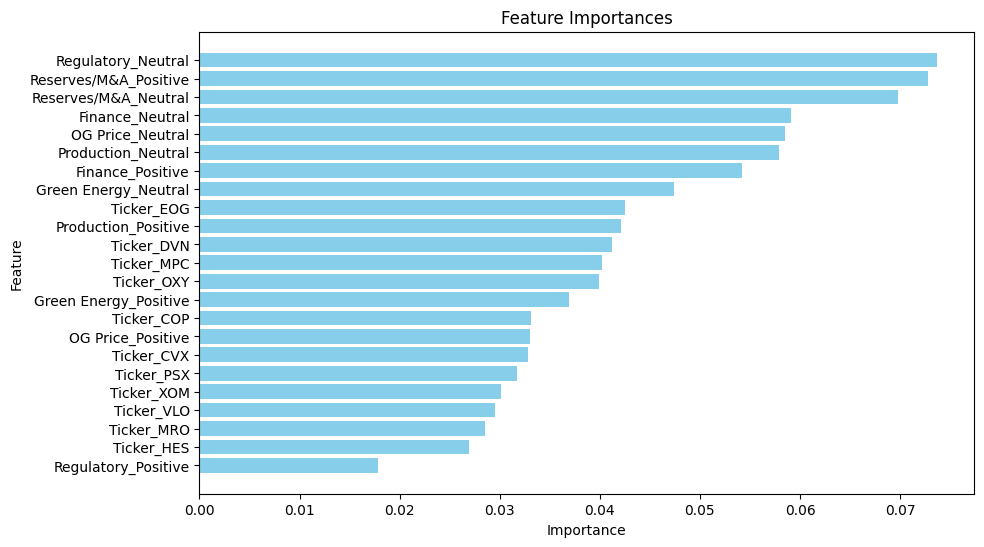

In [11]:
# Extract feature importances from the best model
importances = best_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        34
           1       0.55      0.49      0.51        37

    accuracy                           0.52        71
   macro avg       0.52      0.52      0.52        71
weighted avg       0.52      0.52      0.52        71



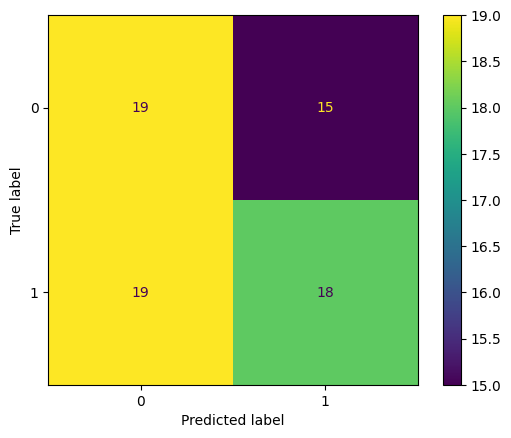

In [12]:
# Random Forest Tuned with GridSearchCV using TimeSeriesSplit

# Define the parameter grid
param_grid = {
   'n_estimators': [100, 250, 500],
   'max_depth': [None, 10, 20, 30],
   'max_features': ['sqrt', 'log2']
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

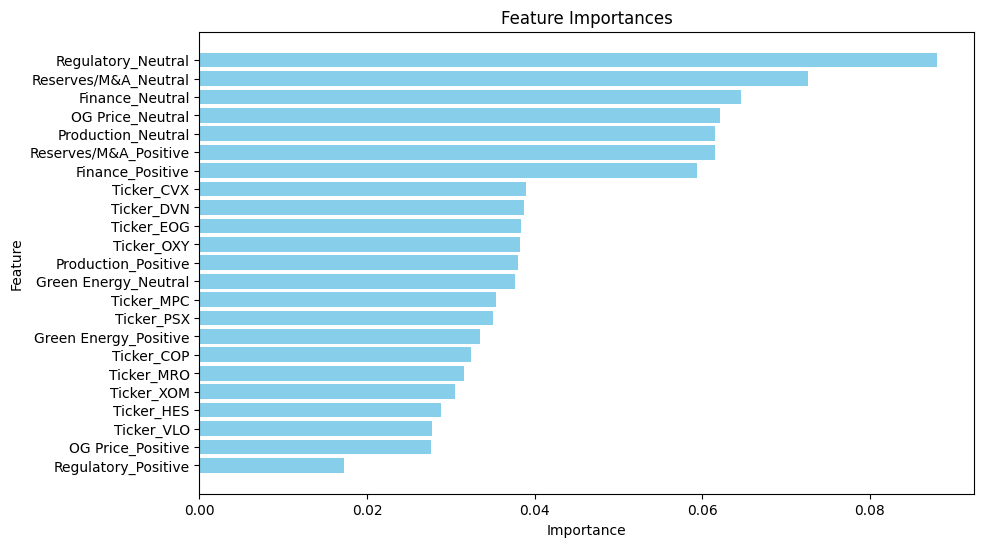

In [13]:
# Extract feature importances from the best model
importances = best_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Manual Tuning as GridSearch had worse results than base model

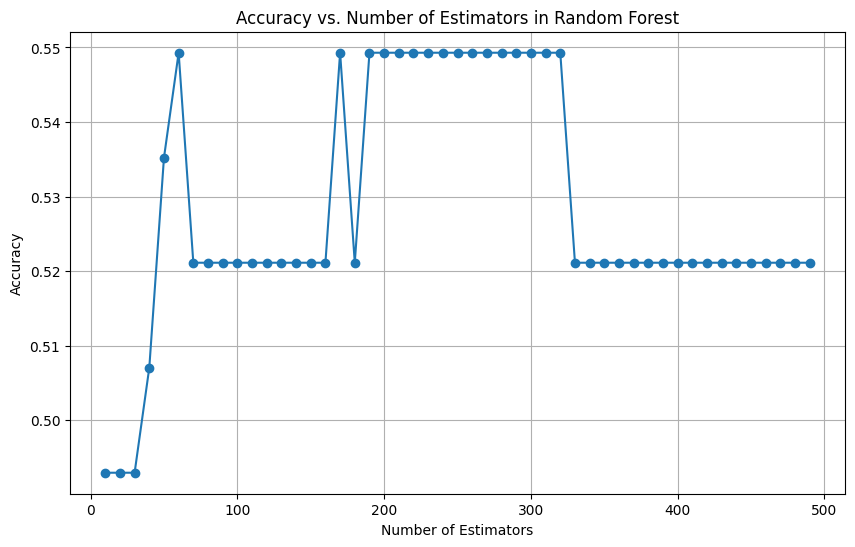

Best Number of Estimators: 60
Best Accuracy Score: 0.5492957746478874
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        34
           1       0.58      0.49      0.53        37

    accuracy                           0.55        71
   macro avg       0.55      0.55      0.55        71
weighted avg       0.55      0.55      0.55        71



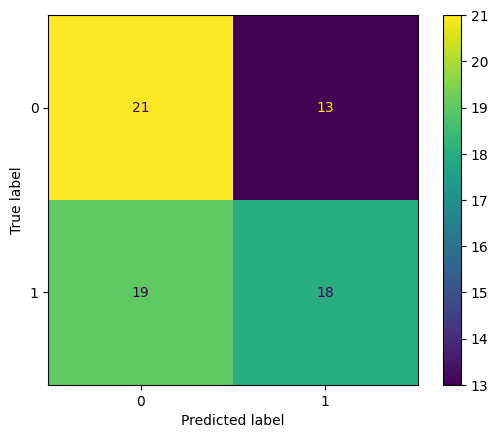

In [14]:
# Plot vs n_estimators
n_estimators_range = range(10, 500, 10)
accuracy_scores = []

# Loop over the n_estimators_range
for n in n_estimators_range:
    rf_clf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Estimators in Random Forest')
plt.grid(True)
plt.show()

# Find the best n_estimators
best_n = n_estimators_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best n_estimators
best_rf_clf = RandomForestClassifier(n_estimators=best_n, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Number of Estimators: {best_n}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

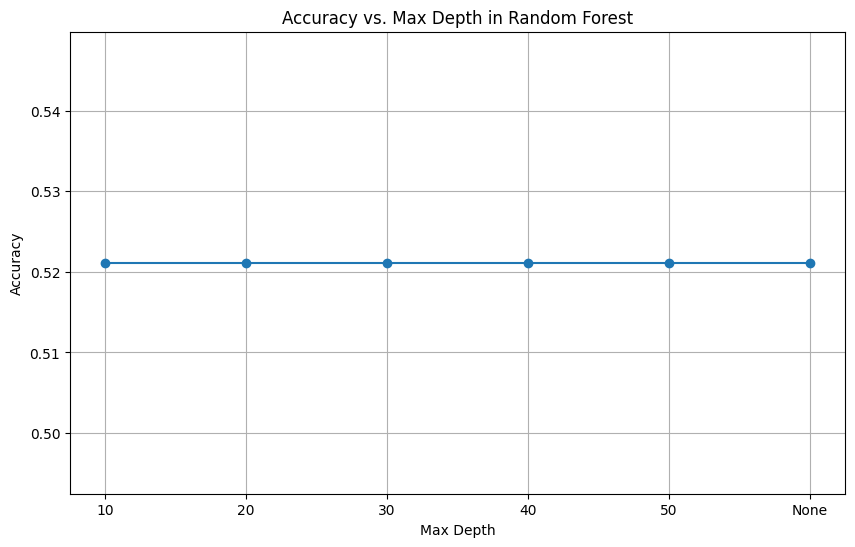

Best Max Depth: 10
Best Accuracy Score: 0.5211267605633803
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        34
           1       0.55      0.49      0.51        37

    accuracy                           0.52        71
   macro avg       0.52      0.52      0.52        71
weighted avg       0.52      0.52      0.52        71



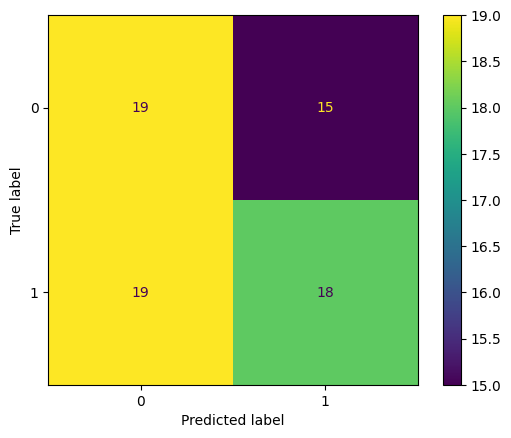

In [15]:
# Plot vs tree depth
max_depth_range = [10, 20, 30, 40, 50, None]
accuracy_scores = []

# Loop over the max_depth_range
for depth in max_depth_range:
    rf_clf = RandomForestClassifier(max_depth=depth, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot([str(depth) for depth in max_depth_range], accuracy_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth in Random Forest')
plt.grid(True)
plt.show()

# Find the best max_depth
best_depth = max_depth_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best max_depth
best_rf_clf = RandomForestClassifier(max_depth=best_depth, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Max Depth: {best_depth}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

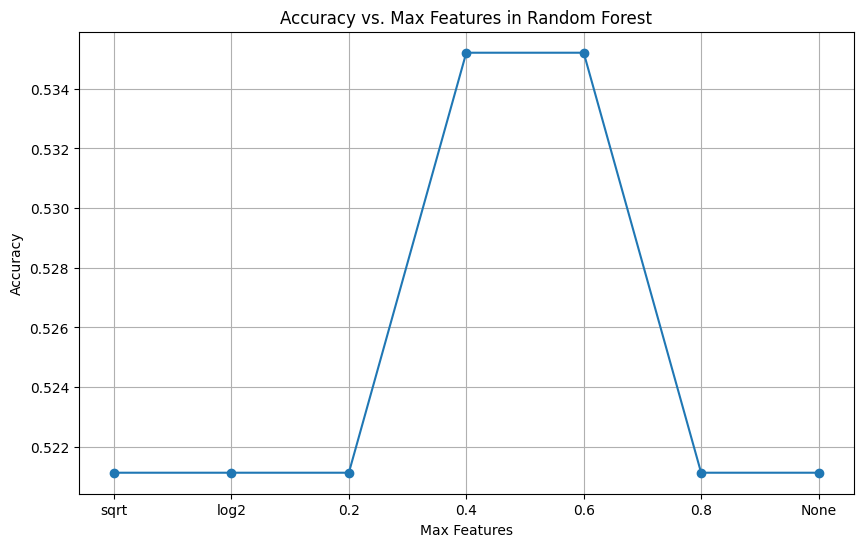

Best Max Features: 0.4
Best Accuracy Score: 0.5352112676056338
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.51      0.56      0.54        34
           1       0.56      0.51      0.54        37

    accuracy                           0.54        71
   macro avg       0.54      0.54      0.54        71
weighted avg       0.54      0.54      0.54        71



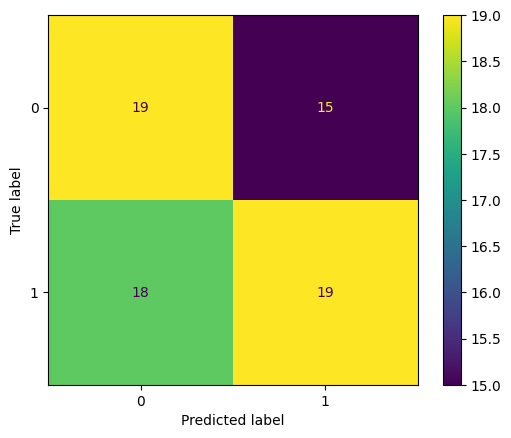

In [16]:
# Plot vs max features
max_features_range = ['sqrt', 'log2', 0.2, 0.4, 0.6, 0.8, None]
accuracy_scores = []

# Loop over the max_features_range
for feature in max_features_range:
    rf_clf = RandomForestClassifier( max_features=feature, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot([str(feature) for feature in max_features_range], accuracy_scores, marker='o')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Features in Random Forest')
plt.grid(True)
plt.show()

# Find the best max_features
best_feature = max_features_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best max_features
best_rf_clf = RandomForestClassifier(max_features=best_feature, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Max Features: {best_feature}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

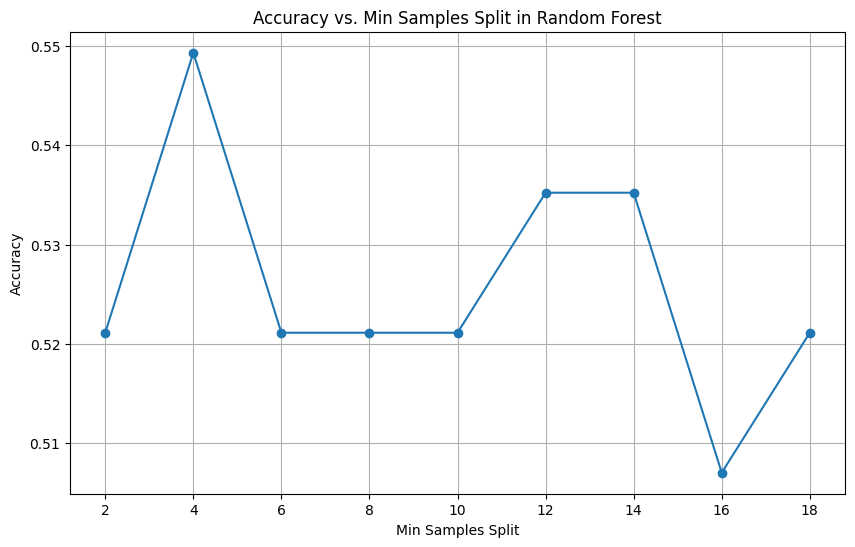

Best Min Samples Split: 4
Best Accuracy Score: 0.5492957746478874
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        34
           1       0.58      0.49      0.53        37

    accuracy                           0.55        71
   macro avg       0.55      0.55      0.55        71
weighted avg       0.55      0.55      0.55        71



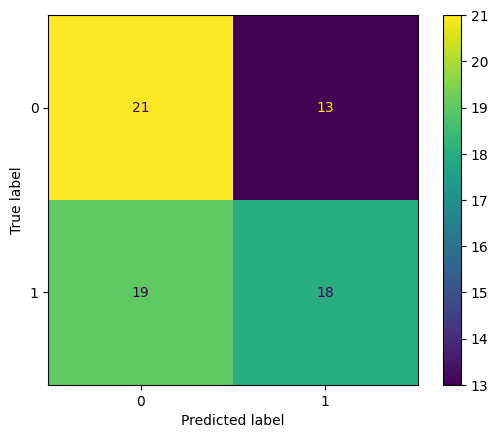

In [17]:
# Plot vs min_samples_split
min_samples_split_range = range(2, 20, 2)
accuracy_scores = []

# Loop over the min_samples_split_range
for split in min_samples_split_range:
    rf_clf = RandomForestClassifier(min_samples_split=split, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_range, accuracy_scores, marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Min Samples Split in Random Forest')
plt.grid(True)
plt.show()

# Find the best min_samples_split
best_split = min_samples_split_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best min_samples_split
best_rf_clf = RandomForestClassifier(min_samples_split=best_split, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Min Samples Split: {best_split}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

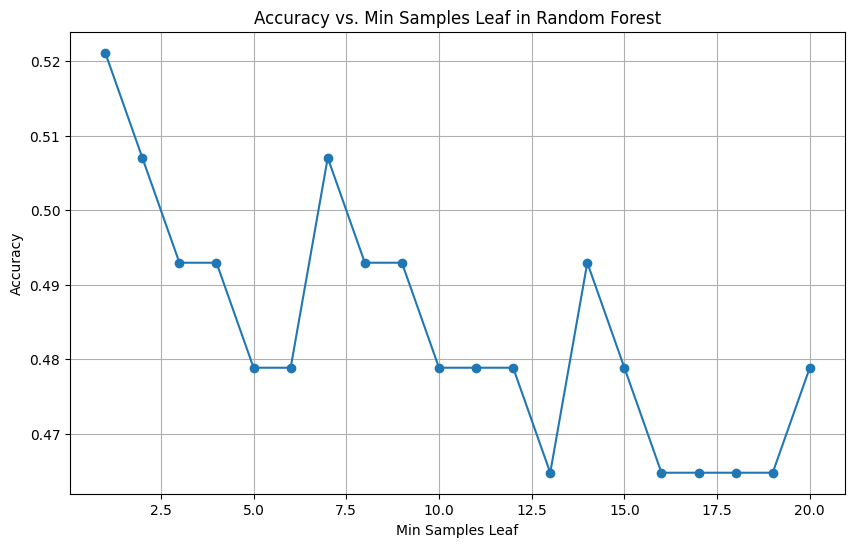

Best Min Samples Leaf: 1
Best Accuracy Score: 0.5211267605633803
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        34
           1       0.55      0.49      0.51        37

    accuracy                           0.52        71
   macro avg       0.52      0.52      0.52        71
weighted avg       0.52      0.52      0.52        71



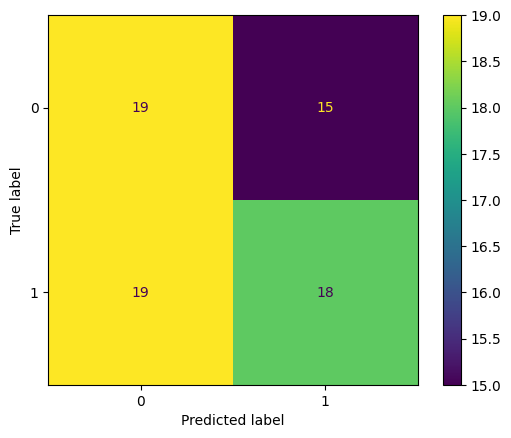

In [18]:
# Plot vs min_samples_leaf
min_samples_leaf_range = range(1, 21)
accuracy_scores = []

# Loop over the min_samples_leaf_range
for leaf in min_samples_leaf_range:
    rf_clf = RandomForestClassifier(min_samples_leaf=leaf, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_range, accuracy_scores, marker='o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Min Samples Leaf in Random Forest')
plt.grid(True)
plt.show()

# Find the best min_samples_leaf
best_leaf = min_samples_leaf_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best min_samples_leaf
best_rf_clf = RandomForestClassifier(min_samples_leaf=best_leaf, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Min Samples Leaf: {best_leaf}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        34
           1       0.58      0.49      0.53        37

    accuracy                           0.55        71
   macro avg       0.55      0.55      0.55        71
weighted avg       0.55      0.55      0.55        71



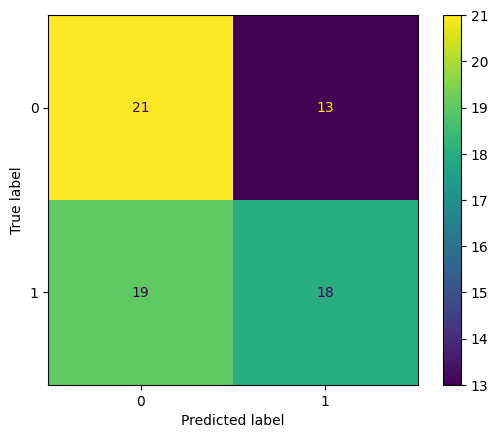

In [19]:
# Manually Tuned Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=250)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test)

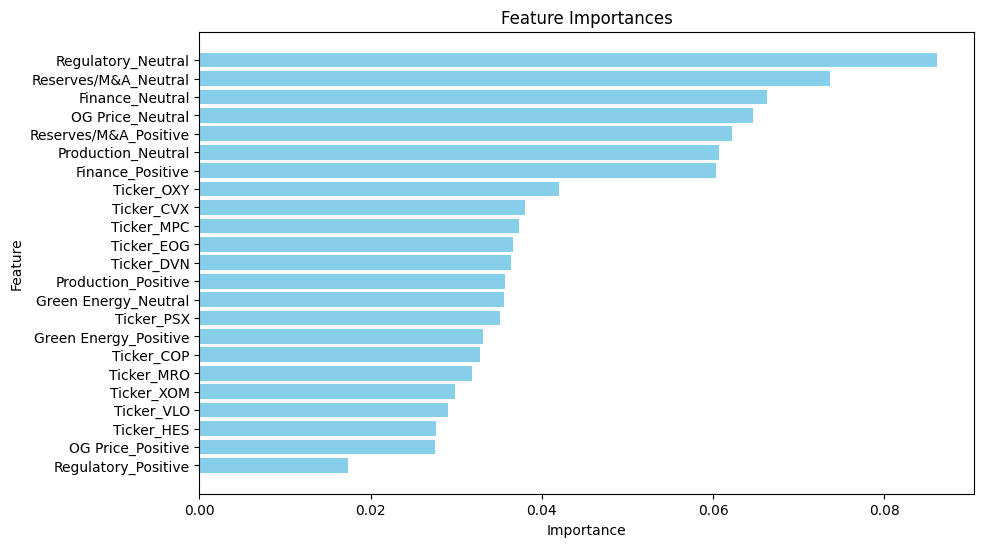

In [20]:
# Extract feature importances from the model
importances = rf_clf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [21]:
# Since dates can have multiple articles and therefore multiple predictions, we can
# pick the result with the highest probability.  This might be important for the next steps,
# but currently this is just a placeholder

# Predict probabilities and classes
y_pred_proba = rf_clf.predict_proba(X_test)
y_pred = rf_clf.predict(X_test)

# Create a DataFrame with the results
results_df = pd.DataFrame(X_test, columns=X_test.columns)
results_df['Actual'] = y_test
results_df['Predicted_Class'] = y_pred
results_df['Predicted_Probability_Class_0'] = y_pred_proba[:, 0]
results_df['Predicted_Probability_Class_1'] = y_pred_proba[:, 1]
display(results_df.head())

,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,Ticker_PSX,Ticker_VLO,...,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive,Actual,Predicted_Class,Predicted_Probability_Class_0,Predicted_Probability_Class_1
948,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,True,False,1,0,0.599520,0.400480
949,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,True,False,1,1,0.400228,0.599772
950,False,False,False,False,False,False,False,False,False,True,...,True,False,True,False,True,False,0,1,0.491995,0.508005
951,False,False,True,False,False,False,False,False,False,False,...,True,False,True,False,True,False,1,0,0.593952,0.406048
952,False,False,False,False,False,False,False,True,False,False,...,True,False,True,False,True,False,1,0,0.773392,0.226608
